# Part 1: Extract Data from Files

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Variable

#Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


version_name = '_final'

#Data URL
train_dir = '../processed_data/train/'
val_dir = '../processed_data/val/'
test_dir = '../processed_data/test/'


#Normalization Function
def norm_data(input: np.array):
    mean = np.mean(input)
    std = np.std(input)
    if std == 0:
        if mean == 0:
            return np.array([-1])
        else:
            # print('std==0')
            input = input / 255.0
    else:
        # print(f'std={std}, mean={mean}')
        input = (input - mean) / std
    return input


#Data Dimension Processing
def de_dimension_data(input: np.array):
    de_data = np.zeros((input.shape[1], input.shape[2]))
    num = 0
    for dimension in input:
        # print('***************')
        norm = norm_data(dimension)
        if np.array_equal(norm, np.array([-1])):
            # print("ALL 0 dimension, give it up. ")
            pass
        else:
            # print("Found effective data, keep it. ")
            num += 1
            de_data = de_data + norm
    if num > 1:
        print('multi layers')
        de_data = norm_data(de_data)
    return de_data


class MNISTDataset(Dataset):
    def __init__(self, device, type='t'):
        self.data = []
        self.labels = []
        self.device = device
        self.type = type
        if self.type == 't':
            print('Type t, wrap all train and val data. ')
            train_folder = sorted(os.listdir(train_dir))
            for label, sub_folder in enumerate(train_folder):
                folder_url = os.path.join(train_dir, sub_folder)
                files = sorted(os.listdir(folder_url))
                for file in files:
                    file_url = os.path.join(folder_url, file)
                    this_data = np.load(file_url)
                    # print(this_data.shape)
                    this_data = de_dimension_data(this_data)
                    # 沿着第一个维度相加
                    # this_data = np.sum(this_data, axis=0)
                    # print(this_data.shape)
                    # this_data = torch.from_numpy(this_data)
                    self.data.append(this_data)
                    self.labels.append(label)
            print(f'train data wrap over, size is {self.data.__len__()}')
            # else:
            val_folder = sorted(os.listdir(val_dir))
            for label, sub_folder in enumerate(val_folder):
                folder_url = os.path.join(val_dir, sub_folder)
                files = sorted(os.listdir(folder_url))
                for file in files:
                    file_url = os.path.join(folder_url, file)
                    this_data = np.load(file_url)
                    # print(data.shape)
                    this_data = de_dimension_data(this_data)
                    # 沿着第一个维度相加
                    # this_data = np.sum(this_data, axis=0)
                    # print(this_data.shape)
                    # this_data = torch.from_numpy(this_data)
                    self.data.append(this_data)
                    self.labels.append(label)
            print(f'val data wrap over, size is {self.data.__len__()}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_label = torch.tensor(int(self.labels[idx]), device=self.device)
        out_data = torch.tensor(self.data[idx], device=self.device)
        out_data = torch.unsqueeze(out_data, dim=0)
        out_label = torch.squeeze(out_label)
        data_pair = {
            'data': out_data,
            'label': out_label
        }
        return data_pair


all_dataset = MNISTDataset(device=device)
# train_dataset = MNISTDataset(device=device, type='t')
# val_dataset = MNISTDataset(device=device, type='v')

print(len(all_dataset))
# print(len(train_dataset))
# print(len(val_dataset))

Type t, wrap all train and val data. 
train data wrap over, size is 60000
val data wrap over, size is 60100
60100


# Part 2: Split Dataset and Prepare for Model

In [2]:
from torch.utils.data import DataLoader

# print(all_dataset[0])
# print(pred_dataset[0])

BATCH_SIZE = 512
EPOCH = 50

train_size = int(0.9 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

print(len(train_dataset))
print(len(val_dataset))

# def collate_fn_train(batch):
#     data = [item['data'].float() for item in batch]
#     # print(inputs)
#     label = [item['label'] for item in batch]
#     # print(labels)
#     return torch.stack(data), torch.tensor(label)
# def collate_fn_pred(batch):
#     data = [item['data'].float() for item in batch]
#     return torch.stack(data)
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)
# test_dataloader = DataLoader(pred_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pred)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

54090
6010


# Part 3: Build CNN Model

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=3),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(2, 2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        # x = x.unsqeeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x


model = Net().to(device)

# Part 4: Decide Optimizer and Loss Function

In [4]:
from torch.utils.tensorboard import SummaryWriter

model.train()
learning_rate = 1e-4
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.99, last_epoch=-1)
writer = SummaryWriter()

# Part 5: Training

In [5]:
import torch.nn.functional as nf

train_loss = 0.0  # 这整个epoch的loss清零
total = 0
correct = 0
log = np.zeros([EPOCH, 3])
iter_num = 0
for epoch in range(EPOCH):
    train_loss_list = []
    for batch_index, traindata in enumerate(train_dataloader):
        # for batch_index, (datas, labels) in enumerate(train_dataloader):
        iter_num += 1
        optimizer.zero_grad()
        data, label = traindata['data'].to(device), traindata['label'].to(device)
        data = data.float()
        # data, label = datas.to(device), labels.to(device)
        # print(data.shape)
        # print(data.dtype)
        output = model.forward(data)
        loss = nf.cross_entropy(output, label)
        writer.add_scalar('Loss/train', loss, iter_num)
        loss.backward()
        optimizer.step()
        train_loss_list += [loss.item()]
        train_loss += loss.item()
        _, predicted = torch.max(output.data, dim=1)
        _, predicted = output.max(1)
        total += data.shape[0]
        correct += predicted.eq(label).sum().item()

        if batch_index % 5 == 4:
            print('[epoch: %d, batch_idx: %d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_index + 1, loss / 100, 100. * correct / total))
            writer.add_scalar('train accuracy per 10 batches', 100. * correct / total, iter_num)
            loss = 0.0
            correct = 0
            total = 0
    scheduler.step()
    log[epoch, 0] = np.mean(train_loss_list)
    correct = 0
    total = 0
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch_index, valdata in enumerate(val_dataloader):
            data, label = valdata['data'].to(device), valdata['label'].to(device)
            data = data.float()
            # for batch_index, (datas, labels) in enumerate(val_dataloader):
            # data, label = datas.to(device), labels.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, dim=1)
            loss = nf.cross_entropy(output, label)
            val_loss.append(loss.item())
            total += label.size(0)
            correct_batch = predicted.eq(label).sum().item()
            correct += predicted.eq(label).sum().item()
            acc_batch = correct_batch / label.size(0)
            print('[batch_index: %d]: Accuracy on val set: %.1f %% ' % (batch_index, 100 * acc_batch))  # 求测试的准确率，正确数/总数
            predicted_list = predicted.tolist()
            targets_list = label.tolist()
            writer.add_scalar('val accuracy per batch', 100 * acc_batch, batch_index)
    acc = correct / total
    print('Average accuracy on val set: %.1f %% ' % (100. * acc))  # 求测试的准确率，正确数/总数
    log[epoch, 1] = np.mean(val_loss)
    log[epoch, 2] = acc

[epoch: 1, batch_idx: 5]: loss: 0.023 , acc: 11.84 %
[epoch: 1, batch_idx: 10]: loss: 0.023 , acc: 11.02 %
[epoch: 1, batch_idx: 15]: loss: 0.023 , acc: 10.12 %
[epoch: 1, batch_idx: 20]: loss: 0.023 , acc: 10.31 %
[epoch: 1, batch_idx: 25]: loss: 0.023 , acc: 10.55 %
[epoch: 1, batch_idx: 30]: loss: 0.023 , acc: 9.69 %
[epoch: 1, batch_idx: 35]: loss: 0.023 , acc: 10.51 %
[epoch: 1, batch_idx: 40]: loss: 0.023 , acc: 10.66 %
[epoch: 1, batch_idx: 45]: loss: 0.023 , acc: 9.92 %
[epoch: 1, batch_idx: 50]: loss: 0.023 , acc: 10.70 %
[epoch: 1, batch_idx: 55]: loss: 0.023 , acc: 11.56 %
[epoch: 1, batch_idx: 60]: loss: 0.023 , acc: 11.45 %
[epoch: 1, batch_idx: 65]: loss: 0.023 , acc: 11.64 %
[epoch: 1, batch_idx: 70]: loss: 0.023 , acc: 11.48 %
[epoch: 1, batch_idx: 75]: loss: 0.023 , acc: 10.70 %
[epoch: 1, batch_idx: 80]: loss: 0.023 , acc: 11.29 %
[epoch: 1, batch_idx: 85]: loss: 0.023 , acc: 12.42 %
[epoch: 1, batch_idx: 90]: loss: 0.023 , acc: 10.51 %
[epoch: 1, batch_idx: 95]: loss

# Part 6: Plot Accuracy Figure

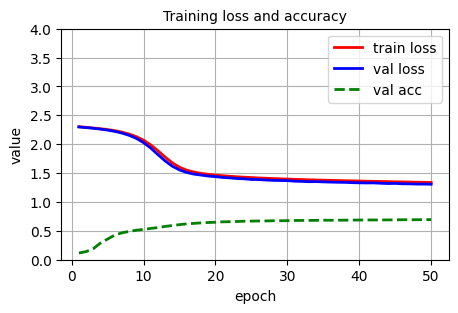

In [6]:
from matplotlib import pyplot as plt

figure_x = np.arange(EPOCH)
figure_x += 1
plt.figure(figsize=(5, 3))
plt.plot(figure_x, log[:, 0], linestyle='-', label='train loss', color='r', linewidth=2)
plt.plot(figure_x, log[:, 1], linestyle='-', color='b', label='val loss', linewidth=2)
plt.plot(figure_x, log[:, 2], linestyle='--', color='g', label='val acc', linewidth=2)
plt.title('Training loss and accuracy', fontsize=10)
plt.xlabel('epoch', fontsize=10)
plt.ylabel('value', fontsize=10)
plt.legend(fontsize=10)
plt.ylim(0, 4)
plt.grid()
# plt.savefig('../Results/training_loss_record.png')
plt.show()
with open('../Results/Loss_and_Acc' + version_name + '.csv', 'w') as file:
    # 遍历列表中的元素并将其写入文件
    for i in range(EPOCH):
        file.write(str(i) + ',' + str(log[i, 0]) + ',' + str(log[i, 1]) + ',' + str(log[i, 2]) + '\n')

# Part 7: Save Model State Dict

In [7]:
save_info = {
    "iter_num": iter_num, "optimizer": optimizer.state_dict(), "model": model.state_dict()
}
save_path = '../Results/model' + version_name + '.pth'
torch.save(save_info, save_path)

# Part 8: Model Test

In [8]:
import math

# print(data_test_loader.batch_size)
predicted_list = []
count_test = 0
model.eval()  # 切换模型为测试状态(没加drop_out层，因此这句话可以随便注释掉)
test_files = os.listdir(test_dir)
test_files.sort(key=lambda x: int(x.split('.')[0]))
for file in test_files:
    file_url = os.path.join(test_dir, file)
    # print(file_url)
    this_data = np.load(file_url)
    # 沿着第一个维度相加
    # this_data = np.sum(this_data, axis=0)
    this_data = de_dimension_data(this_data)
    this_data = torch.tensor(this_data, device=device)
    this_data = torch.unsqueeze(this_data, dim=0)
    this_data = this_data.float()
    this_data = this_data.to(device)
    out = model(Variable(this_data))
    problt = torch.nn.functional.softmax(out, dim=1)
    problt = Variable(problt)
    problt = problt.cpu().numpy()
    pred = np.argmax(problt)
    predicted_list.append(pred.item())

# Part 9: Save Test Result into File

In [9]:
count = 0
with open('../Results/Predict' + version_name + '.txt', 'w') as file:
    # 遍历列表中的元素并将其写入文件
    for item in predicted_list:
        file.write(str(count) + '.npy' + ' ')
        file.write(str(item) + '\n')
        count = count + 1
# 将预测结果写入Predict.csv文件中
with open('../Results/Predict' + version_name + '.csv', 'w') as file:
    # file.write("predicted class label" + '\n')
    # 遍历列表中的元素并将其写入文件
    for item in predicted_list:
        file.write(str(item) + '\n')

# Part 10: Visualize neural network model information

In [10]:
from torchviz import make_dot
from torchsummary import summary
## 查看模型的size
summary(model, input_size=(1, 28, 28))
# 创建虚拟输入，可视化计算图
dummy_input = torch.randn(512, 1, 28, 28)
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.render("cnn_computation_graph", format="png", cleanup=True)